%matplotlib inline


# Manifold learning on handwritten digits: Locally Linear Embedding, Isomap...

An illustration of various embeddings on the digits dataset.

The RandomTreesEmbedding, from the :mod:`sklearn.ensemble` module, is not
technically a manifold embedding method, as it learn a high-dimensional
representation on which we apply a dimensionality reduction method.
However, it is often useful to cast a dataset into a representation in
which the classes are linearly-separable.

t-SNE will be initialized with the embedding that is generated by PCA in
this example, which is not the default setting. It ensures global stability
of the embedding, i.e., the embedding does not depend on random
initialization.

Linear Discriminant Analysis, from the :mod:`sklearn.discriminant_analysis`
module, and Neighborhood Components Analysis, from the :mod:`sklearn.neighbors`
module, are supervised dimensionality reduction method, i.e. they make use of
the provided labels, contrary to other methods.


In [57]:
# Authors: Fabian Pedregosa <fabian.pedregosa@inria.fr>
#          Olivier Grisel <olivier.grisel@ensta.org>
#          Mathieu Blondel <mathieu@mblondel.org>
#          Gael Varoquaux
# License: BSD 3 clause (C) INRIA 2011

from time import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import offsetbox
from sklearn import (manifold, datasets, decomposition, ensemble,
                     discriminant_analysis, random_projection, neighbors)

In [76]:
digits = datasets.load_digits(n_class=6)
X = digits.data
y = digits.target
n_samples, n_features = X.shape
n_neighbors = 30

In [77]:
digits.images.shape

(1083, 8, 8)

In [78]:
digits.images[0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

In [79]:
n_samples

1083

In [80]:
n_features

64

In [81]:
X.shape

(1083, 64)

In [63]:
X[:5]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
        15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
        12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
         0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
        10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.],
       [ 0.,  0.,  0., 12., 13.,  5.,  0.,  0.,  0.,  0.,  0., 11., 16.,
         9.,  0.,  0.,  0.,  0.,  3., 15., 16.,  6.,  0.,  0.,  0.,  7.,
        15., 16., 16.,  2.,  0.,  0.,  0.,  0.,  1., 16., 16.,  3.,  0.,
         0.,  0.,  0.,  1., 16., 16.,  6.,  0.,  0.,  0.,  0.,  1., 16.,
        16.,  6.,  0.,  0.,  0.,  0.,  0., 11., 16., 10.,  0.,  0.],
       [ 0.,  0.,  0.,  4., 15., 12.,  0.,  0.,  0.,  0.,  3., 16., 15.,
        14.,  0.,  0.,  0.,  0.,  8., 13.,  8., 16.,  0.,  0.,  0.,  0.,
         1.,  6., 15., 11.,  0.,  0.,  0.,  1.,  8., 13., 15.,  1.,  0.,
         0.,  0.,  9., 16., 16.,  5.,  0.,  0.,  0.,  0.,  

In [64]:
y[:18]

array([0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5])

In [65]:
# Scale and visualize the embedding vectors
def plot_embedding(X, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

    shown_images = np.array([[1., 1.]])  # just something big
    for i in range(X.shape[0]):
        dist = np.sum((X[i] - shown_images) ** 2, 1)
        if np.min(dist) < 4e-3:
            # don't show points that are too close
            continue
        shown_images = np.r_[shown_images, [X[i]]]
        imagebox = offsetbox.AnnotationBbox(
            offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
            X[i])
        ax.add_artist(imagebox)
    
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

In [66]:
X[0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

Text(0.5, 1.0, 'A selection from the 64-dimensional digits dataset')

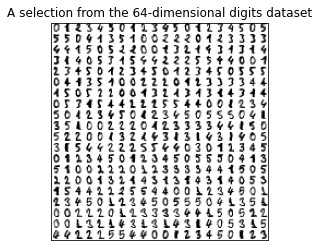

In [69]:
# Plot images of the digits
n_img_per_row = 20
img = np.zeros((10 * n_img_per_row, 10 * n_img_per_row))
for i in range(n_img_per_row):
    ix = 10 * i + 1
    for j in range(n_img_per_row):
        iy = 10 * j + 1
        img[ix:ix + 8, iy:iy + 8] = X[i * n_img_per_row + j].reshape((8, 8))

plt.imshow(img, cmap=plt.cm.binary)
plt.xticks([])
plt.yticks([])
plt.title('A selection from the 64-dimensional digits dataset')

Computing random projection


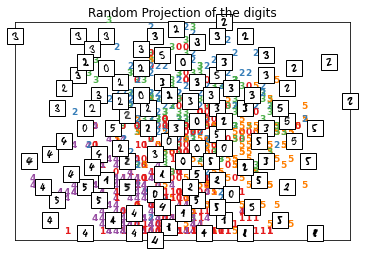

In [70]:
# Random 2D projection using a random unitary matrix
print("Computing random projection")
rp = random_projection.SparseRandomProjection(n_components=2, random_state=42)
X_projected = rp.fit_transform(X)
plot_embedding(X_projected, "Random Projection of the digits")

Computing PCA projection


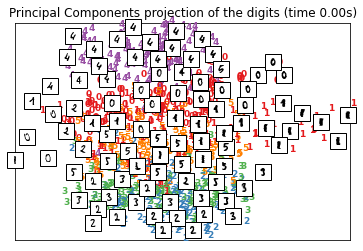

In [71]:
# Projection on to the first 2 principal components

print("Computing PCA projection")
t0 = time()
X_pca = decomposition.TruncatedSVD(n_components=2).fit_transform(X)
plot_embedding(X_pca,
               "Principal Components projection of the digits (time %.2fs)" %
               (time() - t0))

Computing Linear Discriminant Analysis projection


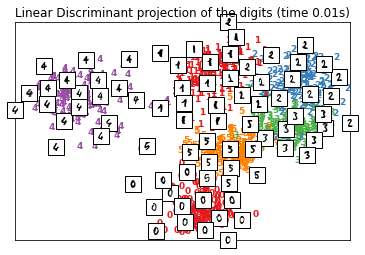

In [72]:
# Projection on to the first 2 linear discriminant components

print("Computing Linear Discriminant Analysis projection")
X2 = X.copy()
X2.flat[::X.shape[1] + 1] += 0.01  # Make X invertible
t0 = time()
X_lda = discriminant_analysis.LinearDiscriminantAnalysis(n_components=2
                                                         ).fit_transform(X2, y)
plot_embedding(X_lda,
               "Linear Discriminant projection of the digits (time %.2fs)" %
               (time() - t0))

Computing Isomap projection
Done.


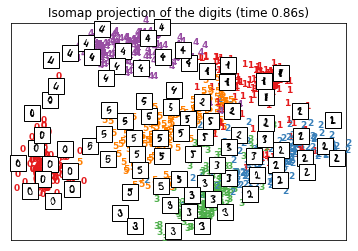

In [10]:
# Isomap projection of the digits dataset
print("Computing Isomap projection")
t0 = time()
X_iso = manifold.Isomap(n_neighbors=n_neighbors, n_components=2
                        ).fit_transform(X)
print("Done.")
plot_embedding(X_iso,
               "Isomap projection of the digits (time %.2fs)" %
               (time() - t0))

Computing LLE embedding
Done. Reconstruction error: 1.63545e-06


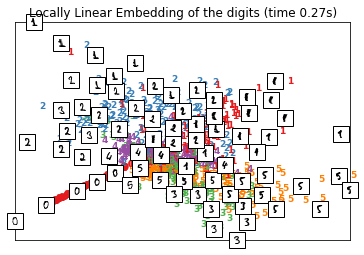

In [11]:
# Locally linear embedding of the digits dataset
print("Computing LLE embedding")
clf = manifold.LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=2,
                                      method='standard')
t0 = time()
X_lle = clf.fit_transform(X)
print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
plot_embedding(X_lle,
               "Locally Linear Embedding of the digits (time %.2fs)" %
               (time() - t0))

Computing modified LLE embedding
Done. Reconstruction error: 0.36067


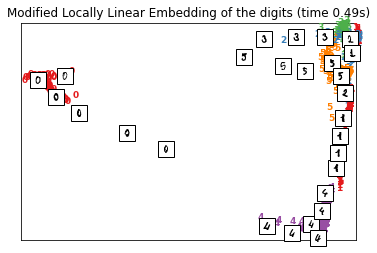

In [12]:
# Modified Locally linear embedding of the digits dataset
print("Computing modified LLE embedding")
clf = manifold.LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=2,
                                      method='modified')
t0 = time()
X_mlle = clf.fit_transform(X)
print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
plot_embedding(X_mlle,
               "Modified Locally Linear Embedding of the digits (time %.2fs)" %
               (time() - t0))

Computing Hessian LLE embedding
Done. Reconstruction error: 0.21281


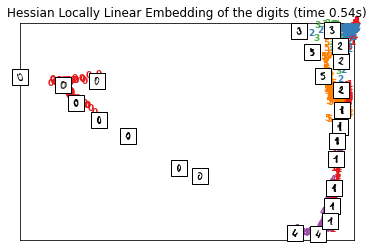

In [13]:
# HLLE embedding of the digits dataset
print("Computing Hessian LLE embedding")
clf = manifold.LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=2,
                                      method='hessian')
t0 = time()
X_hlle = clf.fit_transform(X)
print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
plot_embedding(X_hlle,
               "Hessian Locally Linear Embedding of the digits (time %.2fs)" %
               (time() - t0))

Computing LTSA embedding
Done. Reconstruction error: 0.212804


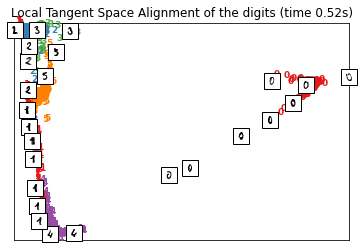

In [14]:
# LTSA embedding of the digits dataset
print("Computing LTSA embedding")
clf = manifold.LocallyLinearEmbedding(n_neighbors=n_neighbors, n_components=2,
                                      method='ltsa')
t0 = time()
X_ltsa = clf.fit_transform(X)
print("Done. Reconstruction error: %g" % clf.reconstruction_error_)
plot_embedding(X_ltsa,
               "Local Tangent Space Alignment of the digits (time %.2fs)" %
               (time() - t0))

Computing MDS embedding
Done. Stress: 174863280.842188


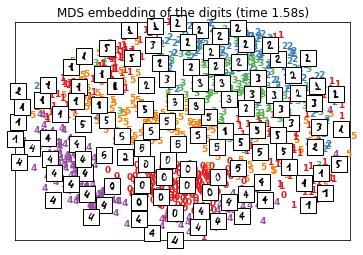

In [15]:
# MDS  embedding of the digits dataset
print("Computing MDS embedding")
clf = manifold.MDS(n_components=2, n_init=1, max_iter=100)
t0 = time()
X_mds = clf.fit_transform(X)
print("Done. Stress: %f" % clf.stress_)
plot_embedding(X_mds,
               "MDS embedding of the digits (time %.2fs)" %
               (time() - t0))

Computing Totally Random Trees embedding


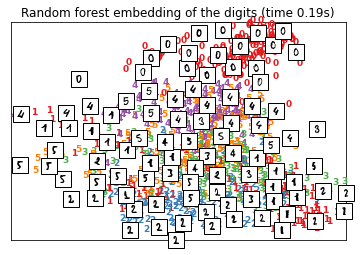

In [16]:
# Random Trees embedding of the digits dataset
print("Computing Totally Random Trees embedding")
hasher = ensemble.RandomTreesEmbedding(n_estimators=200, random_state=0,
                                       max_depth=5)
t0 = time()
X_transformed = hasher.fit_transform(X)
pca = decomposition.TruncatedSVD(n_components=2)
X_reduced = pca.fit_transform(X_transformed)

plot_embedding(X_reduced,
               "Random forest embedding of the digits (time %.2fs)" %
               (time() - t0))

In [45]:
X_reduced.shape

(1083, 2)

In [46]:
X_reduced[:5]

array([[ 7.45385862,  6.78097149],
       [ 8.02798698, -3.17838199],
       [ 6.83117496, -1.88326042],
       [ 7.3092759 , -1.79423397],
       [ 6.24477813,  1.55098425]])

Computing Spectral embedding


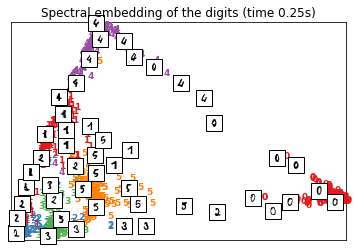

In [17]:
# Spectral embedding of the digits dataset
print("Computing Spectral embedding")
embedder = manifold.SpectralEmbedding(n_components=2, random_state=0,
                                      eigen_solver="arpack")
t0 = time()
X_se = embedder.fit_transform(X)

plot_embedding(X_se,
               "Spectral embedding of the digits (time %.2fs)" %
               (time() - t0))

In [44]:
X_se.shape

(1083, 2)

Computing t-SNE embedding


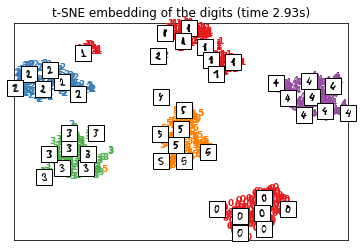

In [18]:
# t-SNE embedding of the digits dataset
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_tsne = tsne.fit_transform(X)

plot_embedding(X_tsne,
               "t-SNE embedding of the digits (time %.2fs)" %
               (time() - t0))

Computing NCA projection


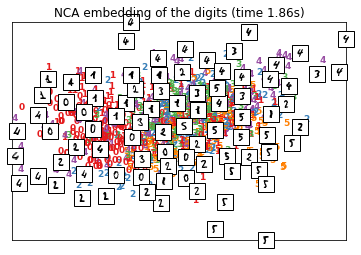

In [19]:
# NCA projection of the digits dataset
print("Computing NCA projection")
nca = neighbors.NeighborhoodComponentsAnalysis(init='random',
                                               n_components=2, random_state=0)
t0 = time()
X_nca = nca.fit_transform(X, y)

plot_embedding(X_nca,
               "NCA embedding of the digits (time %.2fs)" %
               (time() - t0))

plt.show()

In [91]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [92]:
X.shape

(1000, 3)

In [94]:
# Scale and visualize the embedding vectors
def plot_embedding(X, y, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    plt.figure()
    ax = plt.subplot(111)
    for i in range(X.shape[0]):
        plt.text(X[i, 0], X[i, 1], str(y[i]),
                 color=plt.cm.Set1(y[i] / 10.),
                 fontdict={'weight': 'bold', 'size': 9})

#     shown_images = np.array([[1., 1.]])  # just something big
#     for i in range(X.shape[0]):
#         dist = np.sum((X[i] - shown_images) ** 2, 1)
#         if np.min(dist) < 4e-3:
#             # don't show points that are too close
#             continue
#         shown_images = np.r_[shown_images, [X[i]]]
#         imagebox = offsetbox.AnnotationBbox(
#             offsetbox.OffsetImage(digits.images[i], cmap=plt.cm.gray_r),
#             X[i])
#         ax.add_artist(imagebox)
    
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

Computing t-SNE embedding


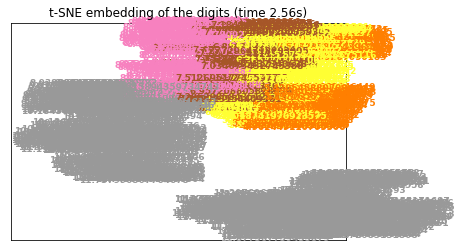

In [95]:
# t-SNE embedding of the digits dataset
print("Computing t-SNE embedding")
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
t0 = time()
X_tsne = tsne.fit_transform(X)

plot_embedding(X_tsne, t,
               "t-SNE embedding of the digits (time %.2fs)" %
               (time() - t0))

Computing PCA projection


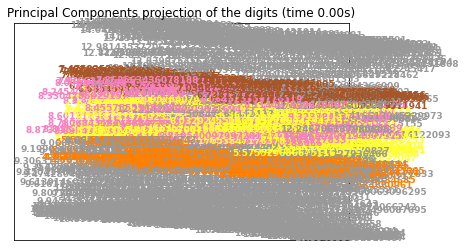

In [96]:
# Projection on to the first 2 principal components

print("Computing PCA projection")
t0 = time()
X_pca = decomposition.TruncatedSVD(n_components=2).fit_transform(X)
plot_embedding(X_pca,t,
               "Principal Components projection of the digits (time %.2fs)" %
               (time() - t0))